In [38]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.0 MB/s eta 0:00:00


In [51]:
import pandas as pd
import numpy as np
# import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# from skimpy import skim

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
# from category_encoders import OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno
import warnings
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler as stdscale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import skopt

In [3]:
#Seaborn settings for visualizations!
rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'YlOrRd'

sns.set(rc=rc)
pd.set_option('display.max_columns',35)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
file_name = '/content/2020_stat.csv'
table = pd.read_csv(file_name, quoting=csv.QUOTE_NONE, on_bad_lines='skip').dropna()

for col in table.columns:
  table.columns = table.columns.str.replace('"', '')

model_data = table[[ 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B','FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'MI_PCT', 'DLQ_30_FLAG', 'DLQ_90_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured']]
for col in model_data.select_dtypes(include=['object']).columns:
    model_data[col] = model_data[col].str.replace('"', '', regex=False)
    model_data[col] = pd.to_numeric(model_data[col], errors='coerce')
model_data = model_data.dropna()
model_data

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,NUM_UNIT,OCC_Principal,OCC_Second,OCC_Investor,MI_PCT,DLQ_30_FLAG,DLQ_90_FLAG,Ongoing,Current_DLQ,Prepaid_Matured
0,3.38,"308,000.00",180,75.00,1,38.00,796.00,1,0,0,1,1,1,0,0,0.00,0,0,0,0,1
1,3.62,"207,000.00",240,66.00,2,25.00,806.00,0,0,1,0,1,1,0,0,0.00,0,0,0,0,1
2,3.62,"215,000.00",240,73.00,2,42.00,745.00,0,0,1,0,1,1,0,0,0.00,0,0,0,0,1
3,4.00,"319,000.00",360,75.00,2,25.00,774.00,0,0,1,0,1,1,0,0,0.00,0,0,0,0,1
4,4.12,"362,000.00",360,78.00,1,38.00,763.00,0,0,1,0,1,1,0,0,0.00,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817642,2.88,"136,000.00",360,46.00,1,45.00,804.00,0,0,1,0,1,1,0,0,0.00,0,0,1,0,0
4817643,2.99,"208,000.00",360,64.00,2,38.00,751.00,0,1,0,0,1,1,0,0,0.00,0,0,0,0,1
4817644,3.12,"214,000.00",360,94.00,1,34.00,712.00,0,0,1,0,1,1,0,0,30.00,1,0,0,0,1
4817645,3.38,"118,000.00",360,80.00,1,43.00,660.00,1,0,0,1,1,1,0,0,0.00,0,0,1,0,0


In [7]:
# Definition of Bad Loans: once had a 90-day delinquency in performance history
# Definition of Good Loans: no delinquency and continuous payments up to current
model_data = model_data[ (model_data['DLQ_90_FLAG'] == 1) | ( (model_data['DLQ_90_FLAG'] == 0) & (model_data['Ongoing'] == 1) ) ]
model_data = model_data.astype(float)
X = model_data.drop(columns=['DLQ_30_FLAG', 'DLQ_90_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured'])
y = model_data['DLQ_90_FLAG']


In [10]:
num_col = ['ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C',
           'NUM_UNIT', 'MI_PCT']
cat_col = ['FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'OCC_Principal', 'OCC_Second', 'OCC_Investor']
scaler = stdscale()
X[num_col] = scaler.fit_transform(X[num_col])
X = pd.concat([X[num_col], X[cat_col]], axis=1)

X

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT,MI_PCT,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,OCC_Principal,OCC_Second,OCC_Investor
5,5.97,-0.04,0.58,0.56,-0.96,1.21,-2.73,-0.11,-0.51,0.00,1.00,0.00,0.00,1.00,0.00,0.00
10,2.08,0.22,0.58,-0.01,-0.96,-0.40,-2.29,-0.11,-0.51,0.00,1.00,0.00,0.00,1.00,0.00,0.00
14,1.31,1.31,0.58,0.56,0.98,-0.10,-0.71,-0.11,-0.51,0.00,0.00,1.00,0.00,1.00,0.00,0.00
18,1.58,-1.01,0.58,1.41,-0.96,-0.91,0.60,-0.11,2.22,1.00,0.00,0.00,1.00,1.00,0.00,0.00
19,1.81,-1.44,0.58,1.12,0.98,-2.42,0.74,-0.11,1.76,1.00,0.00,0.00,1.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817638,-2.56,-0.69,-1.83,-2.94,-0.96,-0.91,0.40,-0.11,-0.51,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4817639,-1.27,0.37,0.58,-0.80,-0.96,-1.82,0.55,-0.11,-0.51,0.00,0.00,1.00,0.00,1.00,0.00,0.00
4817642,-0.49,-1.02,0.58,-1.36,-0.96,1.21,0.94,-0.11,-0.51,0.00,0.00,1.00,0.00,1.00,0.00,0.00
4817645,0.55,-1.16,0.58,0.56,-0.96,1.01,-2.61,-0.11,-0.51,1.00,0.00,0.00,1.00,1.00,0.00,0.00


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)


### Univariate Analysis

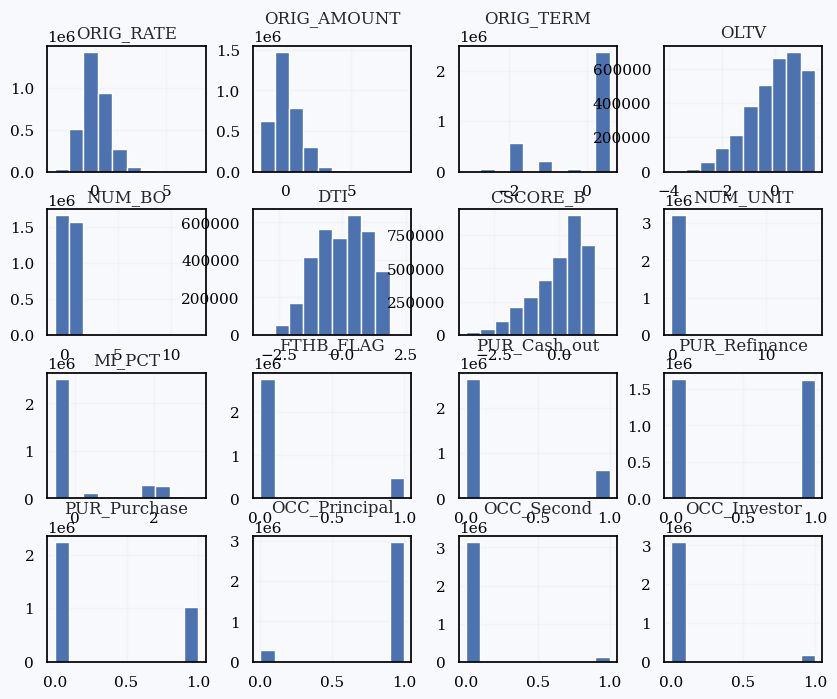

In [12]:
X.hist(figsize=(10,8));

### Bivariate Analysis and heat Map

In [13]:
model_data.corr(method='pearson', numeric_only=True)
fig = go.Figure(go.Heatmap(z=model_data.corr(method='pearson', numeric_only=True), x=model_data.corr(method='pearson', numeric_only=True).columns.tolist(), y=model_data.corr(method='pearson', numeric_only=True).corr().columns.tolist(), colorscale='agsunset'))
fig.show()

#### Missing Values

<Axes: >

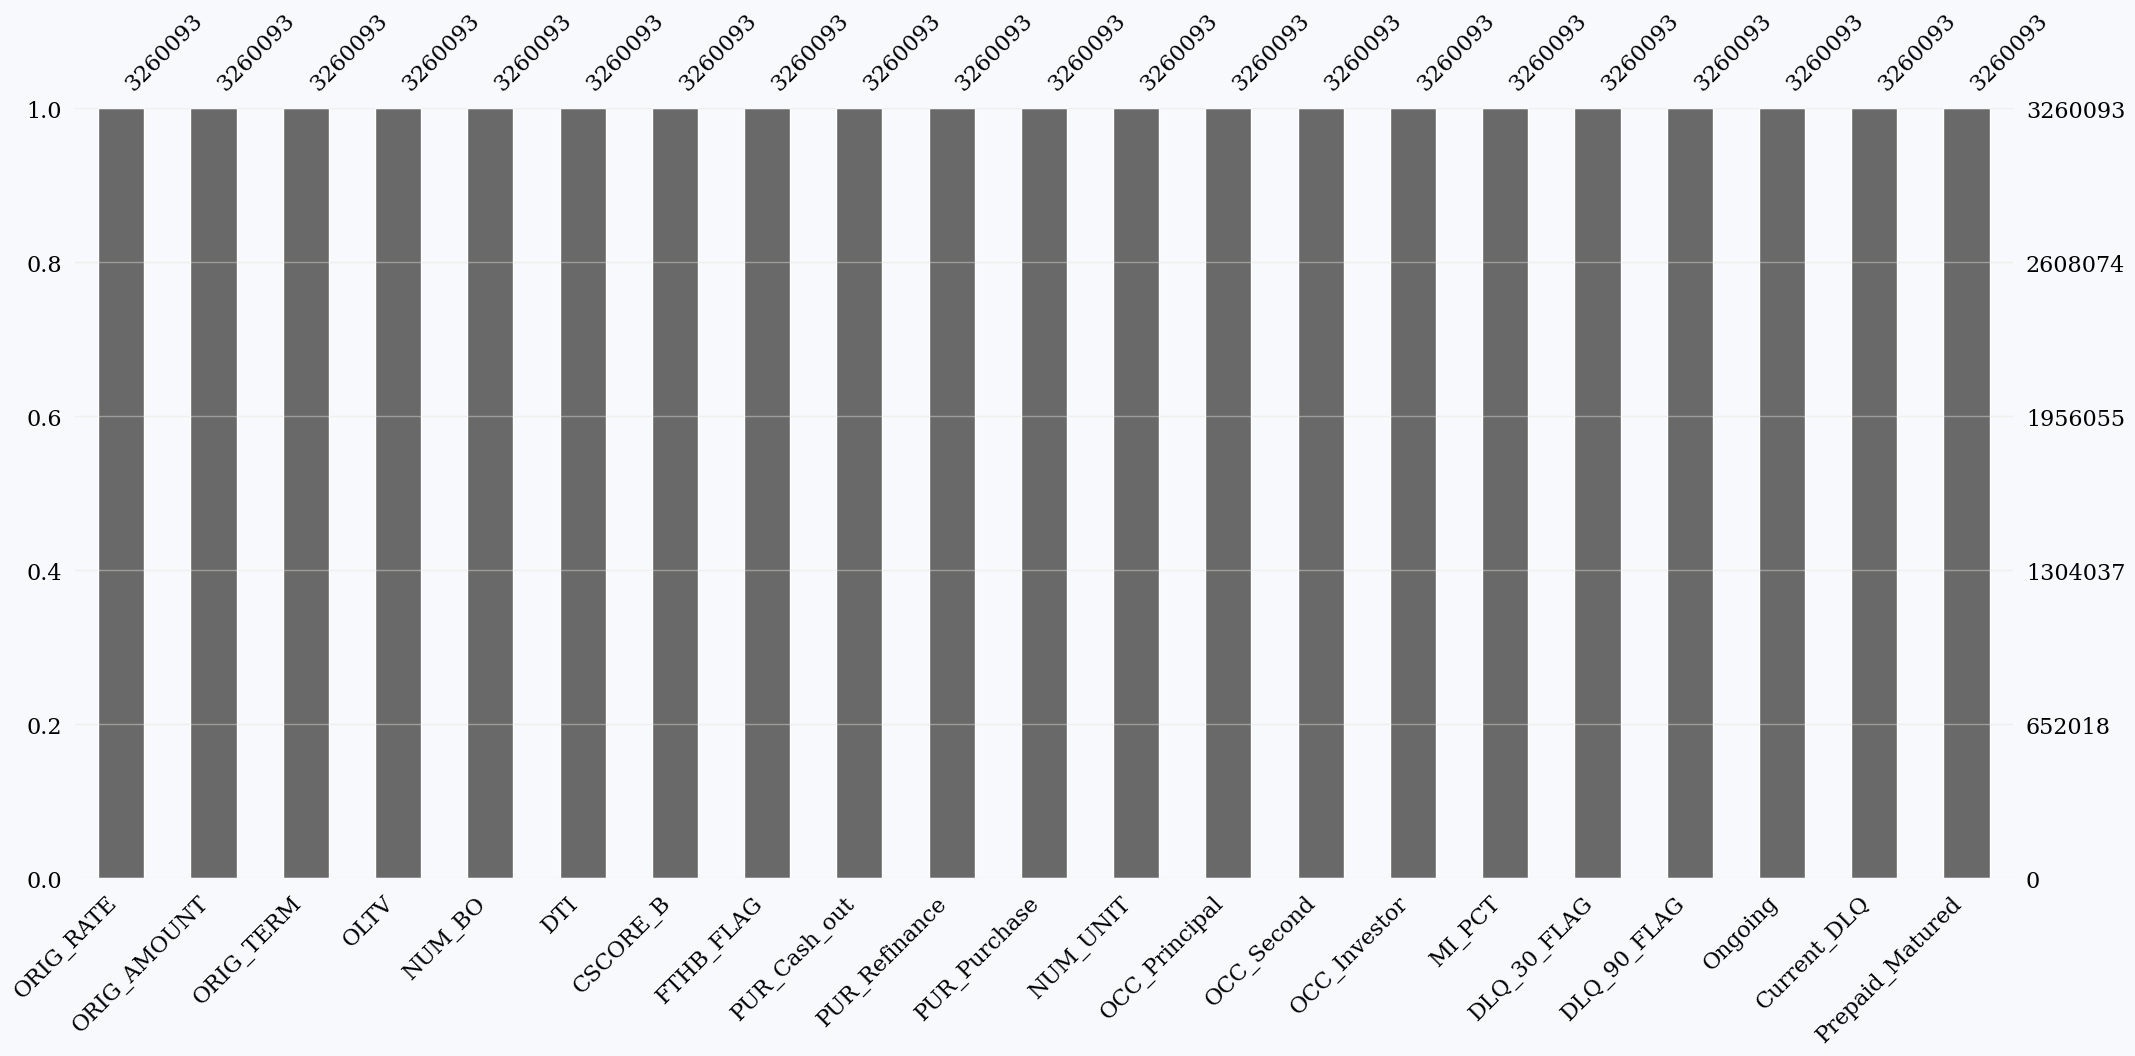

In [14]:
msno.bar(model_data)

In [22]:
model = XGBClassifier(enable_categorical=True, eval_metric='auc')
smote = SMOTE()

pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('model', model)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='auc',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [23]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9431826082688839
AUC-ROC: 0.6125254784909158
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    950161
         1.0       0.17      0.26      0.21     27867

    accuracy                           0.94    978028
   macro avg       0.58      0.61      0.59    978028
weighted avg       0.96      0.94      0.95    978028



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

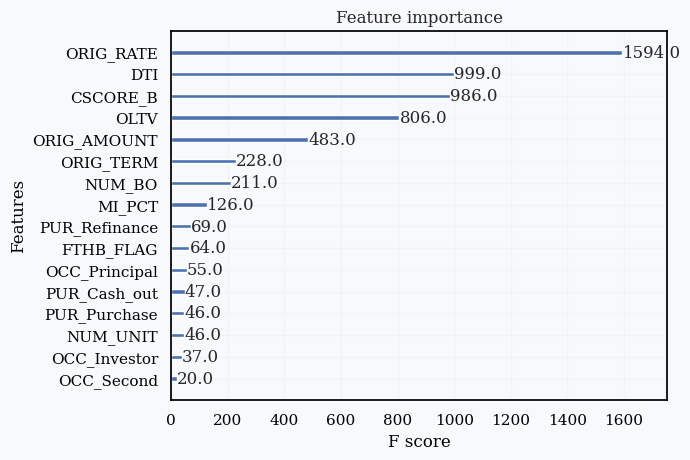

In [30]:
xgb.plot_importance(pipeline['model'])


In [33]:
kfold = KFold(n_splits=10, random_state=42,shuffle= True)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc',cv=kfold)
scores.mean(), scores.std()

KeyboardInterrupt: 

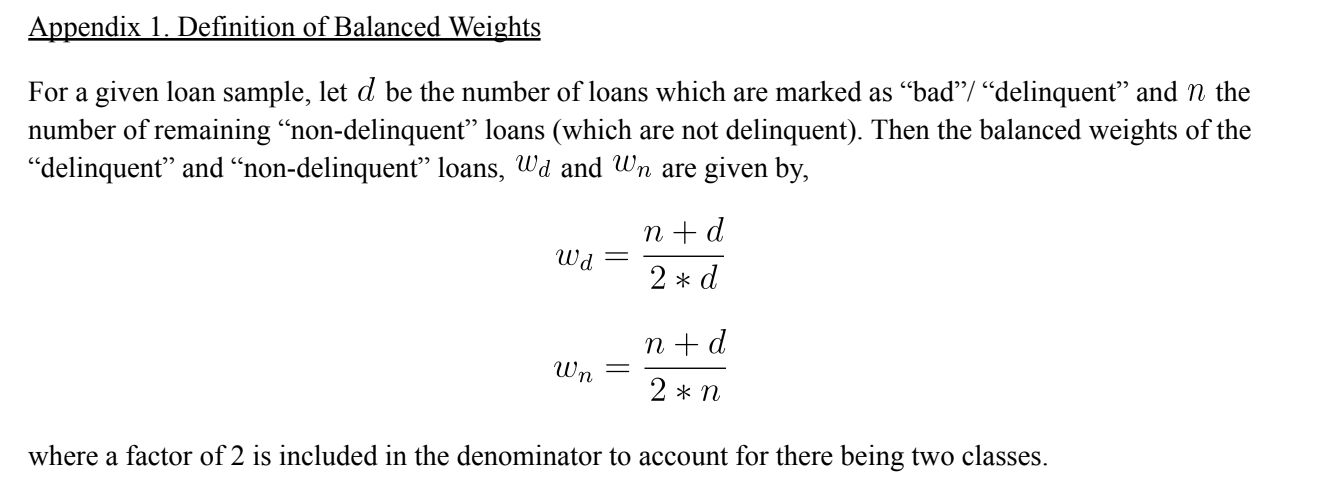

In [34]:
weight_deliquent = len(X_train)/(2*sum(y_train))
scalar_weight_xgb = XGBClassifier(scale_pos_weight=weight_deliquent, eval_metric='auc')
scalar_weight_xgb.fit(X_train, y_train)

y_pred = scalar_weight_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8608250479536373
AUC-ROC: 0.7418447266090463
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    950161
         1.0       0.12      0.62      0.20     27867

    accuracy                           0.86    978028
   macro avg       0.55      0.74      0.56    978028
weighted avg       0.96      0.86      0.90    978028



In [43]:
search_space = {
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.03, "log-uniform"),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.1, 1),
    # "gamma": (1e-8, 1.0, "log-uniform"),
    # "min_child_weight": (1, 10),
}

opt = skopt.BayesSearchCV(
    estimator=XGBClassifier(eval_metric='auc', random=99, scale_pos_weight=weight_deliquent),
    search_spaces=search_space,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=3
)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[16:21:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random" } are not used.




BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='auc', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=Non...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random=99, ...),
              n_iter=20, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': (0.1, 1),
                             'learning_rate': (0.01, 0.03, 'log-uniform'),
                             'max_depth': (3, 10), 'subsample': (0.5, 1.0)},
              verbose=3)

In [45]:
print("Best parameters:", opt.best_params_)
print("Best cross-validation score:", opt.best_score_)

Best parameters: OrderedDict([('colsample_bytree', 0.9208625186943955), ('learning_rate', 0.029999999999999995), ('max_depth', 8), ('subsample', 1.0)])
Best cross-validation score: 0.8442729496912857


In [47]:

optimal_xgb = XGBClassifier(
    scale_pos_weight=weight_deliquent,
    colsample_bytree=0.9208625186943955,
    learning_rate=0.03,
    max_depth=8,
    subsample=1.0,
    eval_metric='auc')
optimal_xgb.fit(X_train, y_train)

y_pred = optimal_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8685732923801772
AUC-ROC: 0.739075008552829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    950161
         1.0       0.12      0.60      0.21     27867

    accuracy                           0.87    978028
   macro avg       0.56      0.74      0.57    978028
weighted avg       0.96      0.87      0.91    978028



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

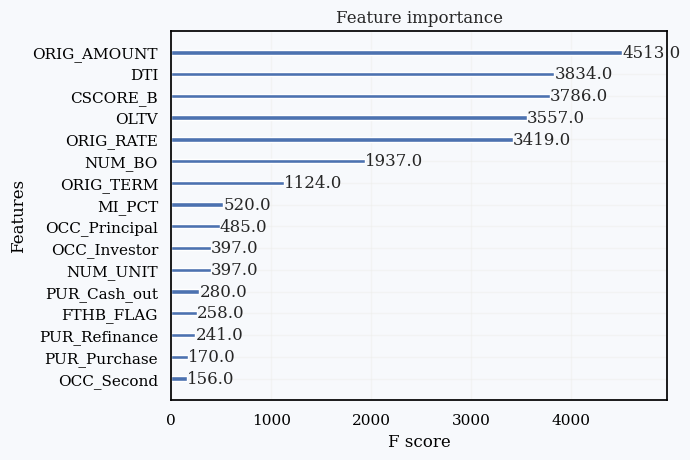

In [49]:
xgb.plot_importance(optimal_xgb)


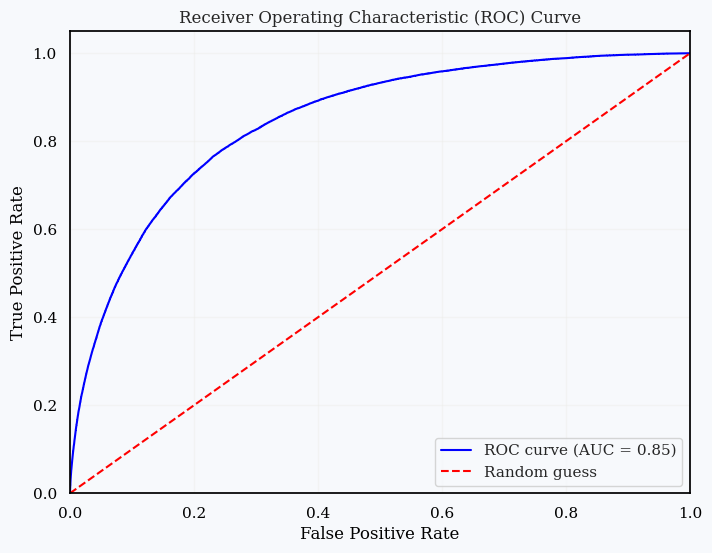

In [52]:
y_pred_proba = optimal_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')